In [115]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime

## Loading the data

In [116]:
yellow = pd.read_csv('yellow.csv')
green = pd.read_csv('green.csv')
FHVHV = pd.read_csv('FHVHV.csv')

In [117]:
yellow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   month_date                              156 non-null    object 
 1   license_class                           156 non-null    object 
 2   trips_per_day                           156 non-null    int64  
 3   farebox_per_day                         156 non-null    int64  
 4   unique_drivers                          156 non-null    int64  
 5   unique_vehicles                         156 non-null    int64  
 6   vehicles_per_day                        156 non-null    int64  
 7   avg_days_vehicles_on_road               156 non-null    float64
 8   avg_hours_per_day_per_vehicle           156 non-null    float64
 9   avg_days_drivers_on_road                156 non-null    float64
 10  avg_hours_per_day_per_driver            156 non-null    float6

In [118]:
Y = yellow.copy()

In [119]:
Y['date'] = pd.to_datetime(Y['date'], format='%Y/%m')
Y['num_date']=Y.date.map(datetime.datetime.toordinal)
Y.set_index('date',inplace=True)
Y = Y.asfreq('MS')
Y.head(2)

,month_date,license_class,trips_per_day,farebox_per_day,unique_drivers,unique_vehicles,vehicles_per_day,avg_days_vehicles_on_road,avg_hours_per_day_per_vehicle,avg_days_drivers_on_road,...,month_year1,trips_per_month,farebox_per_month,week,trips_per_week,year,farebox_per_week,total_trips_per_day,shared_trips_per_day_percent,num_date
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,2010-01-28,Yellow,479376,4968817,30659,13305,12727,29.7,14.3,22.5,...,2010-01,14860656,154033327,4,3355632,2010,34781719,479376,0.0,733773
2010-02-01,2010-02-28,Yellow,397969,3392416,28255,12171,10045,23.1,14.6,17.6,...,2010-02,11143132,94987648,8,2785783,2010,23746912,397969,0.0,733804


In [120]:
print(f'Missing values: {Y.isnull().any(axis=1).mean()}')

Missing values: 0.0


In [121]:
Y.index.freq

<MonthBegin>

In [122]:
# Verificar que un índice temporal está completo
# ==============================================================================
(Y.index == pd.date_range(start = Y.index.min(),end = Y.index.max(), freq = Y.index.freq)).all()

True

In [123]:
# Limita el dataset hasta fin de 2019 (evita efecto COVID-19)
Y = Y.loc[(Y['month_date'] <= '2019-12-31')]

Fechas train : 2010-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=108)
Fechas test  : 2018-12-01 00:00:00 --- 2019-12-01 00:00:00  (n=13)


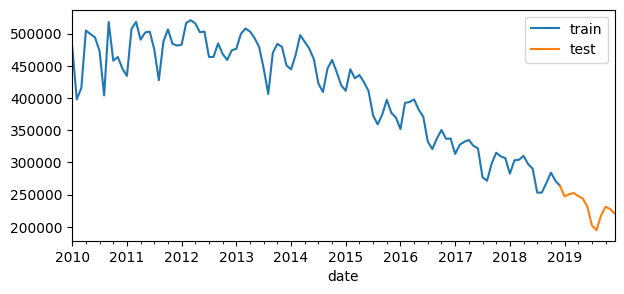

In [124]:
# Separación Y train-test
# ==============================================================================
steps = 12
datos_train = Y[:-steps]
datos_test  = Y[-steps-1:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['trips_per_day'].plot(ax=ax, label='train')
datos_test['trips_per_day'].plot(ax=ax, label='test')
ax.legend()

## Interpolation

In [125]:
# Y = Y.resample('D').interpolate(method='linear')
# Y.head(3)

In [126]:
# print(f'Missing values: {Y.isnull().any().mean()}')

In [127]:
# Verificar que un índice temporal está completo
# ==============================================================================
# (Y.index == pd.date_range(start = Y.index.min(),end = Y.index.max(), freq = Y.index.freq)).all()

In [128]:
# Separación Y train-test
# ==============================================================================
# steps = 365
# datos_train = Y[:-steps]
# datos_test  = Y[-steps:]

# print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
# print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

# fig, ax = plt.subplots(figsize=(7, 3))
# datos_train.plot(ax=ax, label='train')
# datos_test.plot(ax=ax, label='test')
# ax.legend()

## Modeling

In [129]:
# # Acotar los datos desde enero de 2015 hasta diciembre de 2019 (Inicio de crecimiento FHVHV hasta COVID-19)
# green = green.loc[(green['month_date'] >= '2015-01-01') & (green['month_date'] <= '2019-12-31')]

# # Calcular la correlación lineal
# corr = green.corr().iloc[0,1]
# # Graficar la relación entre las variables
# plt.scatter(x=green['month_date'], y=green['trips_per_day'])
# plt.xlabel('month_date')
# plt.ylabel('trips_per_day')
# plt.title(f'Correlación lineal: {corr:.2f}')
# plt.show()

In [130]:
# yellow.loc[(yellow['month_date'] >= '2015-01-01') & (yellow['month_date'] <= '2019-12-31')]

In [131]:
# FHVHV.loc[(FHVHV['month_date'] >= '2015-01-01') & (FHVHV['month_date'] <= '2019-12-31')]

In [132]:
# FHVHV.corr() #.iloc[0,1]

## Trips per day

In [133]:
import datetime as datetime

In [134]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2010-01-01 to 2019-12-01
Freq: MS
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   month_date                              120 non-null    object 
 1   license_class                           120 non-null    object 
 2   trips_per_day                           120 non-null    int64  
 3   farebox_per_day                         120 non-null    int64  
 4   unique_drivers                          120 non-null    int64  
 5   unique_vehicles                         120 non-null    int64  
 6   vehicles_per_day                        120 non-null    int64  
 7   avg_days_vehicles_on_road               120 non-null    float64
 8   avg_hours_per_day_per_vehicle           120 non-null    float64
 9   avg_days_drivers_on_road                120 non-null    float64
 10  avg_hours_per_day_per_driver      

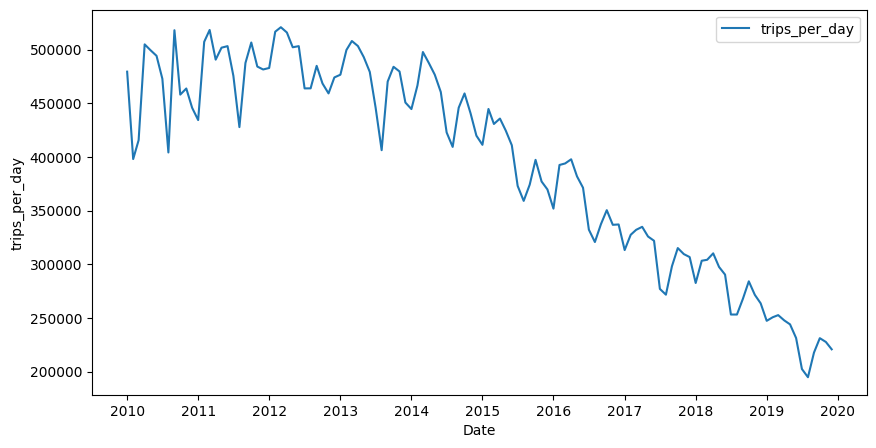

In [135]:
plt.figure(figsize = (10,5))
plt.plot(Y.index, Y.trips_per_day, label = 'trips_per_day')
# plt.plot(Y.month_date, Y.farebox_per_day, label = 'farebox_per_day')
plt.legend()
plt.xlabel('Date')
plt.ylabel('trips_per_day')
#plt.xlim(datetime.date(2015,1,1), datetime.date(2020,1,1))
plt.show()

In [136]:
from sklearn.linear_model import LinearRegression
reg_lineal = LinearRegression() #Instanciamos el modelo
reg_lineal.fit(Y.num_date.values.reshape(-1, 1), Y.trips_per_day) # Lo entrenamos

LinearRegression()

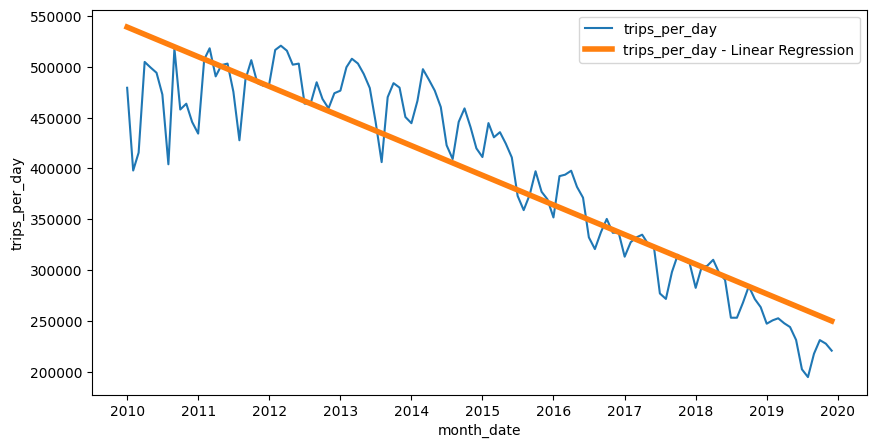

In [137]:
plt.figure(figsize = (10,5)) 
plt.plot(Y.index, Y.trips_per_day, label = 'trips_per_day')
plt.plot(Y.index, reg_lineal.predict(Y.num_date.values.reshape(-1, 1)), lw = 4, label = 'trips_per_day - Linear Regression')
plt.xlabel('month_date')
plt.ylabel('trips_per_day')
plt.legend()
plt.show()

## Estacionalidad

Text(0, 0.5, 'Trips per day')

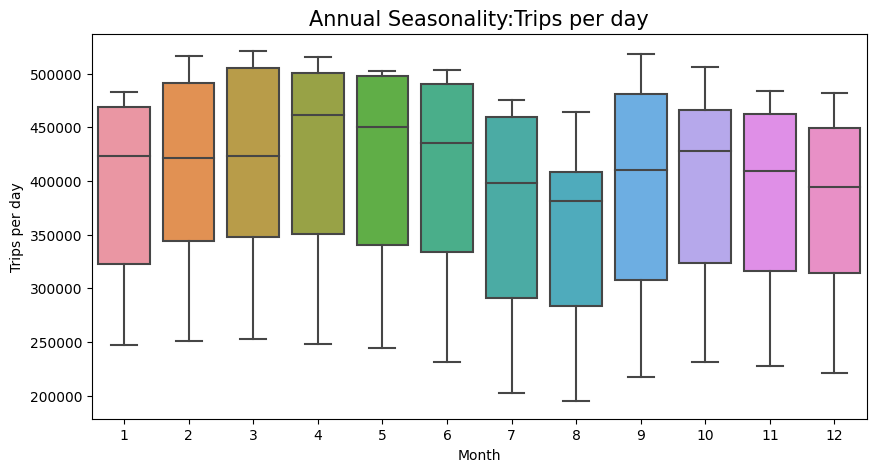

In [138]:
# Agrupamos los datos por mes y mostramos las distribuciones de cada grupo. De esta manera, se visualiza la estacionalidad anual.
plt.figure(figsize = (10,5))
sns.boxplot(data=Y,x=Y.index.month,y= Y.trips_per_day)
plt.title('Annual Seasonality:Trips per day', fontsize = 15)
plt.xlabel('Month')
plt.ylabel('Trips per day')
# Preguntar como obtener la estacionalidad de una tendencia descendente

# Modeling ARIMA

In [139]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels as sm

In [159]:
# Con datos desde 2010 el r2 es 0.34, probemos acortando los datos desde 2015 el r2 es 0.63
y_true = Y['trips_per_day'].loc['2015-01-01':]

## Trips per day

In [161]:
# Este código ajusta un modelo SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) 
# El modelo SARIMAX tiene un orden de (1,1,1) para los términos ARIMA no estacionales y un orden estacional de (1,1,1,12), 
# lo que indica que se modela una estacionalidad de 12 meses.
# En el parámetro seasonal_orden debemos indicar = p estacional, d estacional, q estacional y periodicidad estacional
model=sm.tsa.statespace.sarimax.SARIMAX(y_true,order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59466D+01    |proj g|=  1.21889D+01

At iterate    5    f=  8.13701D+00    |proj g|=  2.00266D-01

At iterate   10    f=  8.13646D+00    |proj g|=  2.24601D-02

At iterate   15    f=  8.13447D+00    |proj g|=  8.60047D-01

At iterate   20    f=  8.11135D+00    |proj g|=  2.30098D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     34      1     0     0   3.229D-03   8.110D+00
  F =   8.1104460533137726     

CONVERG

In [162]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      trips_per_day   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -486.627
Date:                            Mon, 10 Apr 2023   AIC                            983.254
Time:                                    19:10:37   BIC                            992.504
Sample:                                01-01-2015   HQIC                           986.735
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5289      0.629      0.841      0.400      -0.703       1.761
ma.L1         -0.5555      0.607     -0.915      0.360      -1.746       0.635
ar.S.L12      -0.2982      3.932     -0.076      0.940      -8.004       7.408
ma.S.L12       0.3037      3.906      0.078      0.938      -7.351       7.958
sigma2      5.713e+07   8.25e-07   6.93e+13      0.000    5.71e+07    5.71e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.44   Jarque-Bera (JB):                11.62
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -1.00
Prob(H) (two-sided):                  0.93   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.01e+29. Standard errors may be unstable.
"""

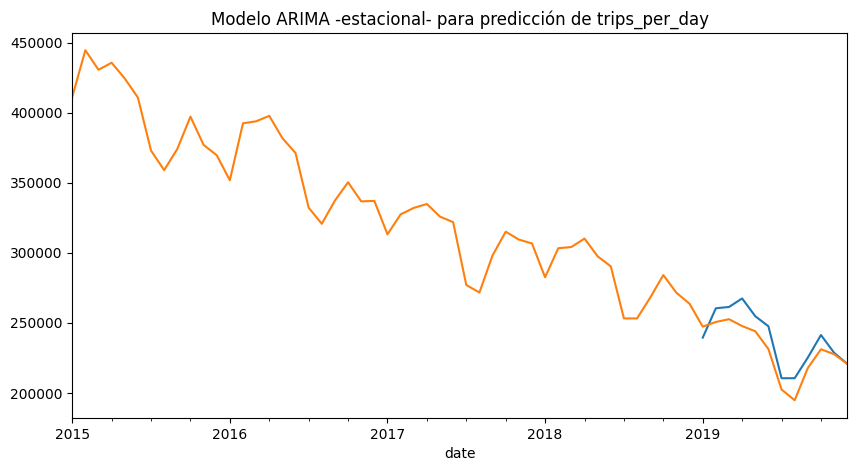

In [163]:
Y['forecast']=results.predict(start=48,end=60,dynamic=True)
y_pred = Y['forecast'].dropna()
y_pred.plot(figsize=(10,5))
y_true.plot(figsize=(10,5))
plt.title('Modelo ARIMA -estacional- para predicción de trips_per_day')
plt.show()

In [164]:
y_pred = Y['forecast'].dropna()
y_true = Y['trips_per_day'].loc['2019-01-01':'2019-12-01']


In [165]:
# R2 Score
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

0.6304166169048406

In [167]:
# Dfino Y a partir de 2015 
Y = Y.loc['2015-01-01':]

In [168]:
# Prediccion a 4 años
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(1, 49)]
# future_dates = [yellow.index[-1]+ DateOffset(months=x)for x in range(0,36)] # 4 años = 48 meses

In [169]:
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y.columns)

In [170]:
future_df = pd.concat([Y,future_datest_df]) # Concatenamos los dos dataframes

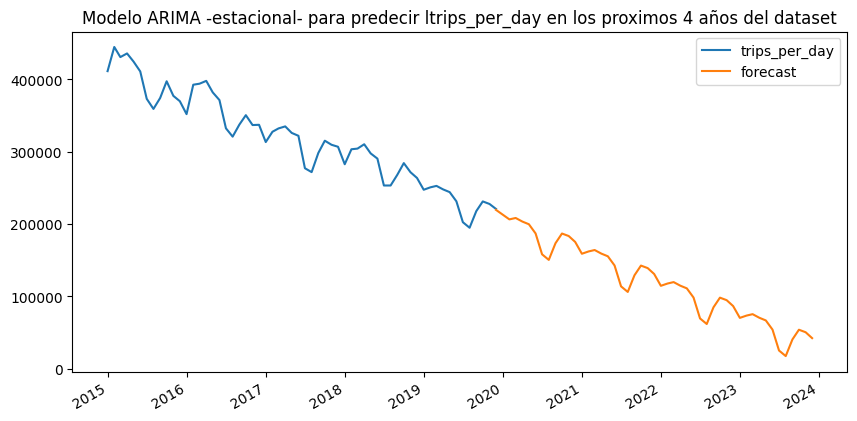

In [172]:
future_df['forecast'] = results.predict(start = 59, end = 108, dynamic= True)  
future_df[['trips_per_day', 'forecast']].plot(figsize=(10, 5)) 
plt.title('Modelo ARIMA -estacional- para predecir ltrips_per_day en los proximos 4 años del dataset')
plt.show()

In [173]:
future_df['forecast']

2015-01-01             NaN
2015-02-01             NaN
2015-03-01             NaN
2015-04-01             NaN
2015-05-01             NaN
                  ...     
2023-08-01    17420.424398
2023-09-01    40422.772031
2023-10-01    53839.357064
2023-11-01    50371.759180
2023-12-01    42214.325643
Name: forecast, Length: 107, dtype: float64

In [174]:
yellow['date'] = pd.to_datetime(yellow['date'], format='%Y/%m')
yellow['num_date']=yellow.date.map(datetime.datetime.toordinal)
yellow.set_index('date',inplace=True)
yellow = yellow.asfreq('MS')

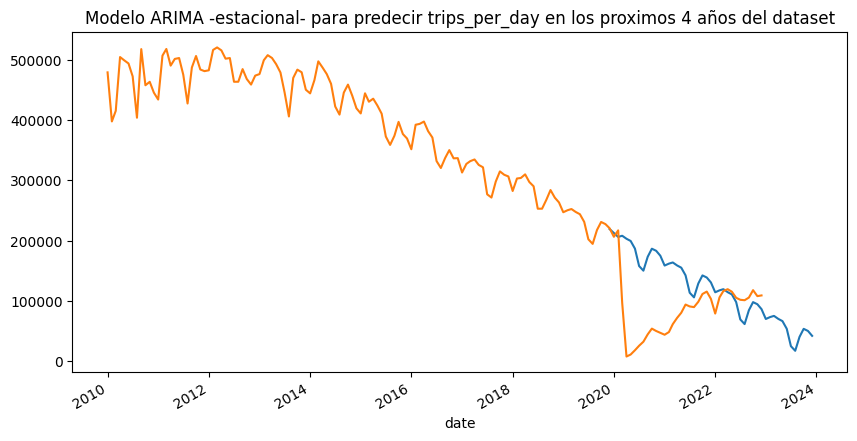

In [175]:
future_df['forecast'] = results.predict(start = 59, end = 108, dynamic= True)  
future_df['forecast'].plot(figsize=(10, 5)) 
yellow['trips_per_day'].plot(figsize=(10, 5)) 
plt.title('Modelo ARIMA -estacional- para predecir trips_per_day en los proximos 4 años del dataset')
plt.show()

In [176]:
# R2 Score
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

0.6304166169048406

## Unique vehicles

Fechas train : 2015-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=48)
Fechas test  : 2018-12-01 00:00:00 --- 2019-12-01 00:00:00  (n=13)


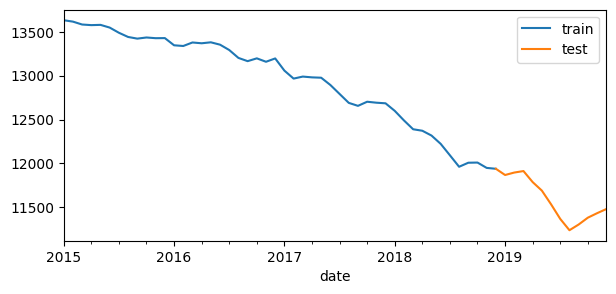

In [231]:

# Separación Y train-test
# ==============================================================================
steps = 12
datos_train = Y[:-steps]
datos_test  = Y[-steps-1:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['unique_vehicles'].plot(ax=ax, label='train')
datos_test['unique_vehicles'].plot(ax=ax, label='test')
ax.legend()

In [86]:
# Limita el dataset desde febrero de 2011 (evita distorsiones)
# Y = Y.loc[(Y['month_date'] >= '2011-02-01')]

Fechas train : 2015-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=48)
Fechas test  : 2018-12-01 00:00:00 --- 2019-12-01 00:00:00  (n=13)


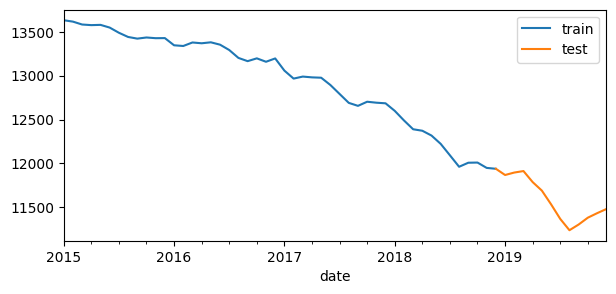

In [232]:

# Separación Y train-test
# ==============================================================================
steps = 12
datos_train = Y[:-steps]
datos_test  = Y[-steps-1:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['unique_vehicles'].plot(ax=ax, label='train')
datos_test['unique_vehicles'].plot(ax=ax, label='test')
ax.legend()

In [233]:
model=sm.tsa.statespace.sarimax.SARIMAX(Y['unique_vehicles'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24331D+00    |proj g|=  1.53749D-01

At iterate    5    f=  4.17136D+00    |proj g|=  6.76244D-02

At iterate   10    f=  4.15801D+00    |proj g|=  4.08361D-03

At iterate   15    f=  4.15608D+00    |proj g|=  6.46178D-03

At iterate   20    f=  4.14891D+00    |proj g|=  7.34894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   1.073D-05   4.149D+00
  F =   4.1489067426833071     

CONVERG

/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_1831/1485075077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['forecast']=results.predict(start=48,end=60,dynamic=True)


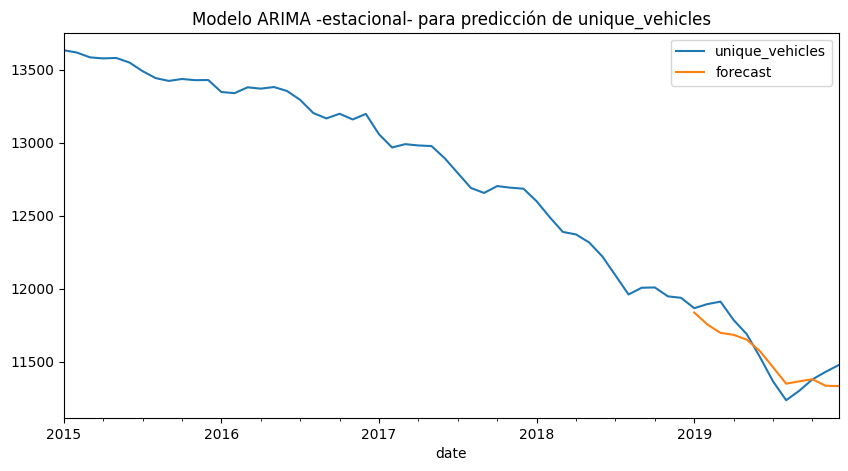

In [234]:
Y['forecast']=results.predict(start=48,end=60,dynamic=True)
Y[['unique_vehicles','forecast']].plot(figsize=(10,5))
plt.title('Modelo ARIMA -estacional- para predicción de unique_vehicles')
plt.show()

In [235]:
y_pred = Y['forecast'].dropna()
y_true = Y['unique_vehicles'].loc['2019-01-01':'2019-12-01']

In [236]:
# R2 Score
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

0.7949352468572031

In [184]:
# Prediccion a 4 años
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(1, 49)]
# future_dates = [yellow.index[-1]+ DateOffset(months=x)for x in range(0,36)] # 4 años = 48 meses
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y.columns)
future_df = pd.concat([Y,future_datest_df]) # Concatenamos los dos dataframes

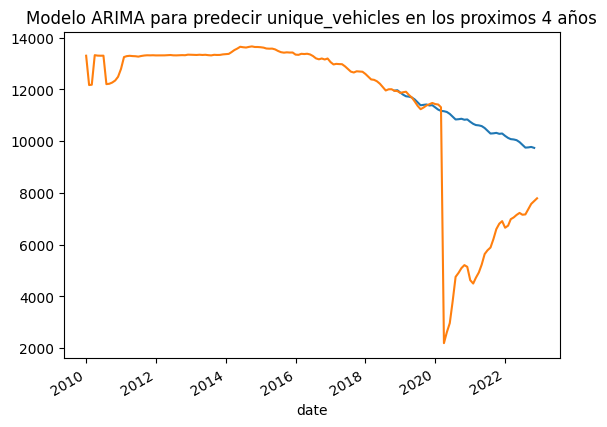

In [186]:
future_df['forecast'] = results.predict(start = 46, end = 94, dynamic= True)  
future_df['forecast'].plot() 
yellow['unique_vehicles'].plot() 
plt.title('Modelo ARIMA para predecir unique_vehicles en los proximos 4 años')
plt.show()

## Farebox per day

Fechas train : 2015-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=48)
Fechas test  : 2018-12-01 00:00:00 --- 2019-12-01 00:00:00  (n=13)


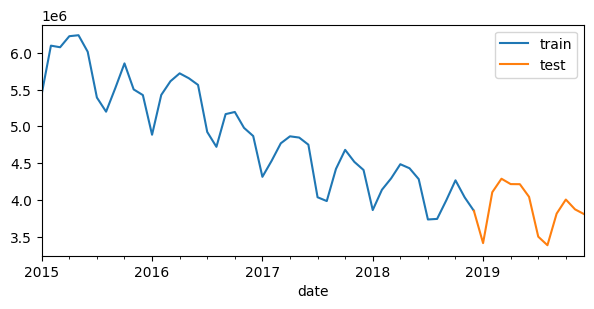

In [237]:
# Separación Y train-test
# ==============================================================================
steps = 12
datos_train = Y[:-steps]
datos_test  = Y[-steps-1:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['farebox_per_day'].plot(ax=ax, label='train')
datos_test['farebox_per_day'].plot(ax=ax, label='test')
ax.legend()

In [238]:
model=sm.tsa.statespace.sarimax.SARIMAX(Y['farebox_per_day'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77697D+01    |proj g|=  1.18350D+01

At iterate    5    f=  1.03584D+01    |proj g|=  8.77289D-04

At iterate   10    f=  1.03584D+01    |proj g|=  1.84750D-02

At iterate   15    f=  1.03582D+01    |proj g|=  2.97662D-02

At iterate   20    f=  1.03519D+01    |proj g|=  5.16595D-01

At iterate   25    f=  1.03451D+01    |proj g|=  4.09029D-02

At iterate   30    f=  1.03381D+01    |proj g|=  5.27847D-02

At iterate   35    f=  1.03347D+01    |proj g|=  2.05376D-03

At iterate   40    f=  1.03347D+01    |proj g|=  1.72562D-03

At iterate   45    f=  1.03344D+01    |proj g|=  1.19465D-02

At iterate   50    f=  1.03342D+01    |proj g|=  4.17460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_1831/1529014274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['forecast']=results.predict(start=48,end=60,dynamic=True)


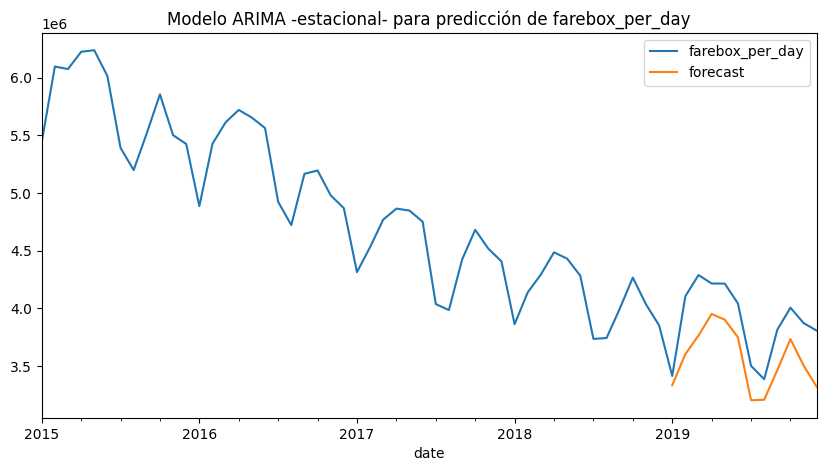

In [239]:
Y['forecast']=results.predict(start=48,end=60,dynamic=True)
Y[['farebox_per_day','forecast']].plot(figsize=(10,5))
plt.title('Modelo ARIMA -estacional- para predicción de farebox_per_day')
plt.show()

In [252]:
# R2 Score
y_pred = Y['forecast'].dropna()/1000000
y_true = Y['farebox_per_day'].loc['2019-01-01':'2019-12-01']/1000000

r2_score(y_true, y_pred)

-0.34469575694160426

In [254]:
# Prediccion a 4 años
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(1, 49)]
# future_dates = [yellow.index[-1]+ DateOffset(months=x)for x in range(0,36)] # 4 años = 48 meses
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y.columns)
future_df = pd.concat([Y,future_datest_df]) # Concatenamos los dos dataframes

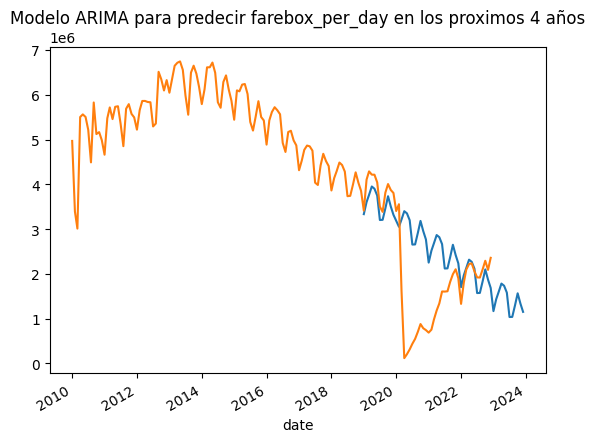

In [255]:
future_df['forecast'] = results.predict(start = 48, end = 108, dynamic= True)  
future_df['forecast'].plot() 
yellow['farebox_per_day'].plot() 
plt.title('Modelo ARIMA para predecir farebox_per_day en los proximos 4 años')
plt.show()

## Average hours per day per vehicle

Fechas train : 2015-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=48)
Fechas test  : 2018-12-01 00:00:00 --- 2019-12-01 00:00:00  (n=13)


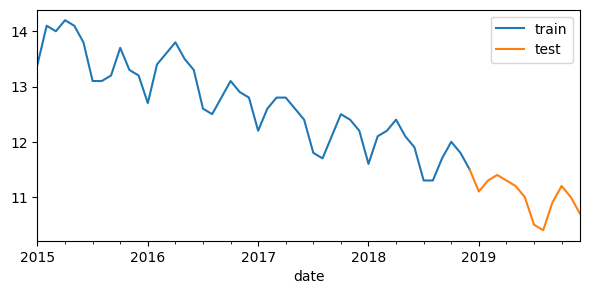

In [257]:

steps = 12
datos_train = Y[:-steps]
datos_test  = Y[-steps-1:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['avg_hours_per_day_per_vehicle'].plot(ax=ax, label='train')
datos_test['avg_hours_per_day_per_vehicle'].plot(ax=ax, label='test')
ax.legend()

In [258]:
model=sm.tsa.statespace.sarimax.SARIMAX(Y['avg_hours_per_day_per_vehicle'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.03912D-01    |proj g|=  9.83437D-01

At iterate    5    f= -5.25980D-01    |proj g|=  1.26414D+00

At iterate   10    f= -5.50556D-01    |proj g|=  4.25821D-02

At iterate   15    f= -5.57321D-01    |proj g|=  3.96350D-01

At iterate   20    f= -5.59128D-01    |proj g|=  2.77212D-02

At iterate   25    f= -5.59278D-01    |proj g|=  5.24101D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     40      1     0     0   

/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_1831/3619116573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['forecast']=results.predict(start=48,end=60,dynamic=True)


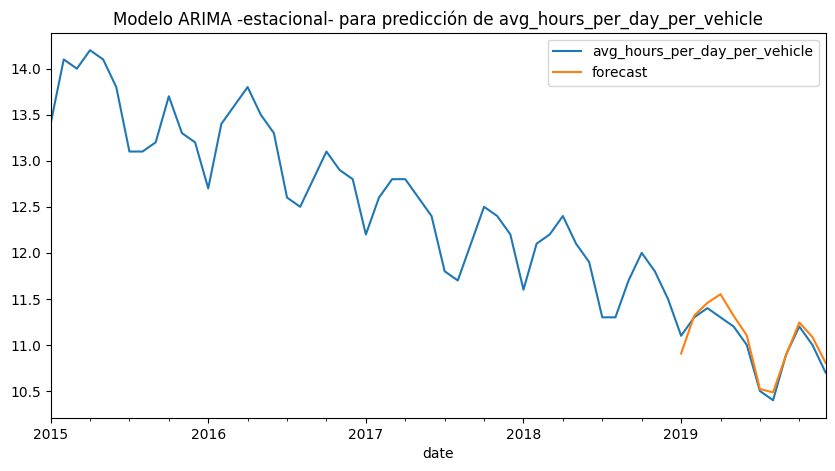

In [259]:
Y['forecast']=results.predict(start=48,end=60,dynamic=True)
Y[['avg_hours_per_day_per_vehicle','forecast']].plot(figsize=(10,5))
plt.title('Modelo ARIMA -estacional- para predicción de avg_hours_per_day_per_vehicle')
plt.show()

In [260]:
# R2 Score
y_pred = Y['forecast'].dropna()
y_true = Y['avg_hours_per_day_per_vehicle'].loc['2019-01-01':'2019-12-01']
r2_score(y_true, y_pred)

0.862890067066198

In [261]:
# Prediccion a 4 años
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(1, 49)]
# future_dates = [yellow.index[-1]+ DateOffset(months=x)for x in range(0,36)] # 4 años = 48 meses
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y.columns)
future_df = pd.concat([Y,future_datest_df]) # Concatenamos los dos dataframes

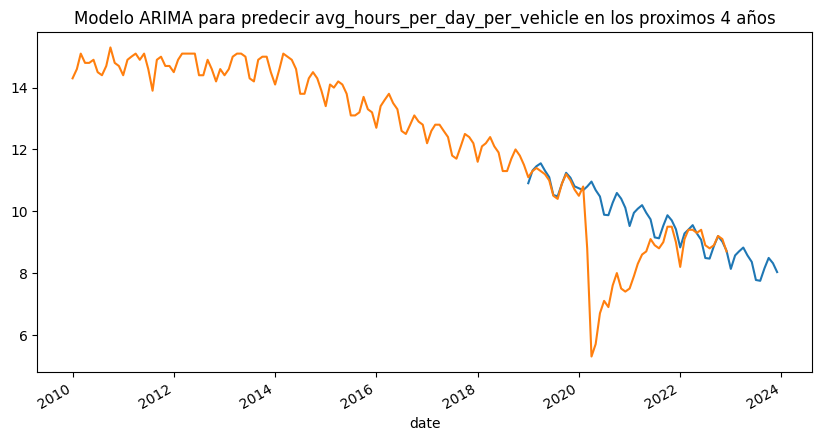

In [262]:
future_df['forecast'] = results.predict(start = 48, end = 154, dynamic= True)  
future_df['forecast'].plot(figsize=(10,5)) 
yellow['avg_hours_per_day_per_vehicle'].plot(figsize=(10,5)) 
plt.title('Modelo ARIMA para predecir avg_hours_per_day_per_vehicle en los proximos 4 años')
plt.show()